In [148]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from PIL import Image, ImageEnhance
from pathlib import Path

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# =============================
# CONFIG
# =============================
DATASET_PATH = Path("COVID-19_Radiography_Dataset/")
BACKUP_PATH = DATASET_PATH.parent / (DATASET_PATH.name + "_backup")
TARGET = 4000
FINAL_SIZE = (100,100)
BACKUP_PATH.mkdir(parents=True, exist_ok=True)
random.seed(42)
np.random.seed(42)

# =============================
# 1. Conteo inicial
# =============================
classes = [d for d in DATASET_PATH.iterdir() if d.is_dir()]
class_counts = {c.name: len(list(c.glob("*"))) for c in classes}
print("Conteo inicial:", class_counts)

# =============================
# 2. Undersampling (para clases con > TARGET)
# =============================
def undersample_class(class_folder: Path, target: int, backup_root: Path):
    files = list(class_folder.glob("*"))
    n = len(files)
    if n <= target:
        return 0
    keep = set(random.sample(files, target))
    moved = 0
    backup_cls = backup_root / class_folder.name
    backup_cls.mkdir(parents=True, exist_ok=True)
    for f in files:
        if f not in keep:
            shutil.move(str(f), str(backup_cls / f.name))
            moved += 1
    return moved

moved_summary = {}
for cls in classes:
    cnt = len(list(cls.glob("*")))
    if cnt > TARGET:
        moved_summary[cls.name] = undersample_class(cls, TARGET, BACKUP_PATH)
print("Imágenes movidas (undersample):", moved_summary)


# =============================
# 3. Recuperar imágenes del BACKUP si faltan
# =============================
def recover_from_backup(class_folder: Path, target: int, backup_root: Path):
    """Si hay menos imágenes que target, recupera algunas del backup."""
    backup_cls = backup_root / class_folder.name
    if not backup_cls.exists():
        return 0
    current = len(list(class_folder.glob("*")))
    backup_files = list(backup_cls.glob("*"))
    if current >= target or len(backup_files) == 0:
        return 0
    needed = target - current
    to_restore = backup_files[:needed]
    restored = 0
    for f in to_restore:
        shutil.move(str(f), str(class_folder / f.name))
        restored += 1
    return restored

restored_summary = {}
for cls in classes:
    restored_summary[cls.name] = recover_from_backup(cls, TARGET, BACKUP_PATH)

print("Imágenes recuperadas del backup:", restored_summary)

# =============================
# 4. Confirmar conteo final
# =============================
final_counts = {c.name: len(list(c.glob('*'))) for c in classes}
print("Conteo final por clase:", final_counts)


Conteo inicial: {'COVID': 50, 'Lung_Opacity': 50, 'Normal': 50, 'Viral Pneumonia': 50}
Imágenes movidas (undersample): {}
Imágenes recuperadas del backup: {'COVID': 50, 'Lung_Opacity': 50, 'Normal': 50, 'Viral Pneumonia': 50}
Conteo final por clase: {'COVID': 100, 'Lung_Opacity': 100, 'Normal': 100, 'Viral Pneumonia': 100}


In [150]:
# Funciones de augmentación
def add_gaussian_noise(pil_img, sigma=8):
    arr = np.array(pil_img).astype(np.float32)
    noise = np.random.normal(0, sigma, arr.shape)
    noisy = np.clip(arr + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy)


def random_affine(pil_img, max_translate=5, max_shear=5):
    w, h = pil_img.size
    trans_x = random.uniform(-max_translate, max_translate)
    trans_y = random.uniform(-max_translate, max_translate)
    shear = random.uniform(-max_shear, max_shear)
    matrix = (1, np.tan(np.radians(shear)), trans_x, np.tan(np.radians(shear)), 1, trans_y)
    return pil_img.transform((w, h), Image.AFFINE, matrix, resample=Image.BILINEAR)

def augment_image(pil_img):
    img = pil_img.copy()
    ops = [
        lambda x: x.transpose(Image.FLIP_LEFT_RIGHT),
        lambda x: x.rotate(random.uniform(-15, 15), resample=Image.BILINEAR),
        lambda x: ImageEnhance.Brightness(x).enhance(random.uniform(0.85, 1.15)),
        lambda x: ImageEnhance.Contrast(x).enhance(random.uniform(0.85, 1.15)),
        lambda x: random_affine(x, max_translate=6, max_shear=3),
        lambda x: add_gaussian_noise(x, sigma=random.uniform(5,12)),
    ]
    for op in random.sample(ops, random.choice([2,3])):
        try: img = op(img)
        except: pass
    return img

FINAL_SIZE = (100,100)

def generate_until_target(class_folder: Path, target: int):
    current_files = list(class_folder.glob("*"))
    count = len(current_files)
    created, idx = 0, 0
    originals = [f for f in current_files if "_aug" not in f.name]
    pbar = tqdm(total=max(0, target - count), desc=f"Aug {class_folder.name}")
    while count < target:
        src = random.choice(originals)
        try:
            img = Image.open(src).convert("L")
        except: continue
        aug = augment_image(img).resize(FINAL_SIZE, Image.BILINEAR)
        new_name = f"{src.stem}_aug{idx:04d}{src.suffix}"
        aug.save(class_folder / new_name)
        idx += 1
        created += 1
        count += 1
        pbar.update(1)
    pbar.close()
    return created

created_summary = {}
for cls in classes:
    cnt = len(list(cls.glob("*")))
    if cnt < TARGET:
        created_summary[cls.name] = generate_until_target(cls, TARGET)
print("Imágenes creadas (augmentation):", created_summary)

final_counts = {c.name: len(list(c.glob('*'))) for c in classes}
print("Conteo final por clase:", final_counts)


Imágenes creadas (augmentation): {}
Conteo final por clase: {'COVID': 100, 'Lung_Opacity': 100, 'Normal': 100, 'Viral Pneumonia': 100}


In [151]:
# Crear DataFrame actualizado
records = []
for cls in classes:
    for f in cls.glob("*"):
        records.append((str(f), cls.name))
df = pd.DataFrame(records, columns=["image_path", "label"])

label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])
print("Total de imágenes balanceadas:", len(df))
print(df["label"].value_counts())

# División en conjuntos
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label_encoded"], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df["label_encoded"], random_state=42)


Total de imágenes balanceadas: 400
label
COVID              100
Lung_Opacity       100
Normal             100
Viral Pneumonia    100
Name: count, dtype: int64


## PERCEPTRON MULTICAPA MLP


In [152]:
# =====================================
# MÓDULO 3.1: MLP (Perceptrón Multicapa)
# =====================================

import torch.nn.functional as F
import time
import math
from collections import defaultdict
import joblib
import seaborn as sns



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Entrenando en:", device)


Entrenando en: cpu


### Modelos MLP (3 diseños)

In [153]:
# =========================
# MODELOS MLP: pequeño / medio / grande
# =========================
class MLP_Small(nn.Module):
    def __init__(self, input_size, num_classes=4, dropout_rate=0.2):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)


class MLP_Medium(nn.Module):
    def __init__(self, input_size, num_classes=4, dropout_rate=0.3):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        return self.fc4(x)


class MLP_Large(nn.Module):
    def __init__(self, input_size, num_classes=4, dropout_rate=0.35):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        return self.fc5(x)


### Feature extractor LBP (offline) — generar y guardar features

Esta celda crea archivos .npz (o .pkl) con los features LBP por split (train, val, test). Intenta usar skimage si está, si no usa una función simple.

In [154]:
# =========================
# LBP FEATURE EXTRACTOR (offline)
# =========================
try:
    from skimage.feature import local_binary_pattern
    SKIMAGE_AVAILABLE = True
except Exception:
    SKIMAGE_AVAILABLE = False

def lbp_histogram(image_pil, P=8, R=1, bins=256, method='default'):
    """
    image_pil: PIL.Image grayscale
    devuelve histograma LBP normalizado (bins,)
    """
    arr = np.array(image_pil, dtype=np.uint8)
    if SKIMAGE_AVAILABLE:
        lbp = local_binary_pattern(arr, P, R, method='default')
        # Histograma sobre el rango 0..(2**P -1)
        max_bins = 2**P
        hist, _ = np.histogram(lbp.ravel(), bins=max_bins, range=(0, max_bins))
    else:
        # fallback: simple 3x3 LBP implementacion (P=8)
        H, W = arr.shape
        lbp = np.zeros_like(arr, dtype=np.uint8)
        for i in range(1, H-1):
            for j in range(1, W-1):
                center = arr[i,j]
                code = 0
                code |= (arr[i-1,j-1] >= center) << 7
                code |= (arr[i-1,j]   >= center) << 6
                code |= (arr[i-1,j+1] >= center) << 5
                code |= (arr[i,j+1]   >= center) << 4
                code |= (arr[i+1,j+1] >= center) << 3
                code |= (arr[i+1,j]   >= center) << 2
                code |= (arr[i+1,j-1] >= center) << 1
                code |= (arr[i,j-1]   >= center) << 0
                lbp[i,j] = code
        hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0,256))
    # normalizar L1
    hist = hist.astype(np.float32)
    if hist.sum() > 0:
        hist /= hist.sum()
    return hist

# Función para procesar un dataframe y crear features .npz
def generate_lbp_features(df_split, out_path, size=(100,100)):
    """
    df_split: DataFrame con columnas image_path, label, label_encoded
    out_path: Path para guardar files (ej: 'features/train_lbp.npz')
    retorna: features numpy (N, B) y labels (N,)
    """
    features = []
    labels = []
    paths = []
    for _, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"LBP {out_path}"):
        p = row['image_path']
        lab = row['label_encoded']
        try:
            img = Image.open(p).convert("L").resize(size)
        except:
            continue
        hist = lbp_histogram(img)
        features.append(hist)
        labels.append(lab)
        paths.append(p)
    features = np.vstack(features).astype(np.float32)
    labels = np.array(labels, dtype=np.int64)
    # guardar
    np.savez_compressed(out_path, features=features, labels=labels, paths=np.array(paths))
    return features, labels

# Ejemplo: generar para train/val/test (usa los df que ya creaste)
FEATURE_DIR = Path("features/")
FEATURE_DIR.mkdir(parents=True, exist_ok=True)

# GENERAR (solo ejecutar una vez; puede tardar)
train_feats, train_labels = generate_lbp_features(train_df, FEATURE_DIR/"train_lbp.npz")
val_feats, val_labels     = generate_lbp_features(val_df, FEATURE_DIR/"val_lbp.npz")
test_feats, test_labels   = generate_lbp_features(test_df, FEATURE_DIR/"test_lbp.npz")


LBP features\test_lbp.npz: 100%|██████████| 40/40 [00:00<00:00, 142.33it/s]


### Datasets para features y para imágenes

In [155]:
# =========================
# DATASETS: ImageDataset y FeatureDataset
# =========================
class FeatureDataset(Dataset):
    def __init__(self, npz_path):
        d = np.load(npz_path)
        self.X = d['features'].astype(np.float32)
        self.y = d['labels'].astype(np.int64)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), int(self.y[idx])

# Para imágenes ya tenías ChestXrayDataset; sino:
class ImageFlatDataset(Dataset):
    def __init__(self, dataframe, size=(100,100), transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.size = size
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        p = self.df.iloc[idx]['image_path']
        y = int(self.df.iloc[idx]['label_encoded'])
        img = Image.open(p).convert("L").resize(self.size)
        arr = np.array(img, dtype=np.float32)/255.0  # normalizamos 0..1
        arr = arr[np.newaxis, ...]  # canal 1
        if self.transform:
            arr = self.transform(torch.tensor(arr))
        return torch.tensor(arr), y


### 5) Entrenamiento / evaluación genérica (mide tiempo)

In [156]:
# =========================
# TRAIN/EVAL genérico (mide tiempo)
# =========================
from sklearn.metrics import accuracy_score

def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=10, device=device):
    model = model.to(device)
    history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}
    start_time = time.time()
    for ep in range(epochs):
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            X = X.to(device).float()
            y = y.to(device).long()
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        # validación
        model.eval()
        val_loss = 0.0
        preds = []
        trues = []
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(device).float()
                yv = yv.to(device).long()
                out = model(Xv)
                lossv = criterion(out, yv)
                val_loss += lossv.item() * Xv.size(0)
                _, p = torch.max(out, 1)
                preds.extend(p.cpu().numpy())
                trues.extend(yv.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        val_acc = 100 * accuracy_score(trues, preds)
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch {ep+1}/{epochs} - train_loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}%")
    total_time = time.time() - start_time

    # Evaluación final en test
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for Xt, yt in test_loader:
            Xt = Xt.to(device).float()
            yt = yt.to(device).long()
            out = model(Xt)
            _, p = torch.max(out, 1)
            y_true.extend(yt.cpu().numpy())
            y_pred.extend(p.cpu().numpy())
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return history, total_time, report, cm


### Orquestador de experimentos (3 modelos × 2 modos: raw / LBP)

In [ ]:
# =========================
# ORQUESTADOR: correr experimentos y guardar resumen
# =========================
EPOCHS = 10
BATCH_SIZE = 64
WEIGHT_DECAY = 1e-4
LR = 1e-3

experiments = []
models_dict = {
    'MLP_Small': MLP_Small,
    'MLP_Medium': MLP_Medium,
    'MLP_Large': MLP_Large
}
""" models_dict = {
    'MLP_Small': MLP_Small,
    'MLP_Medium': MLP_Medium,
    'MLP_Large': MLP_Large
} """

# 1) Experimentos con IMAGENES (raw flattened)
print("== Experimentos sobre IMÁGENES aplanadas ==")
for name, Mclass in models_dict.items():
    print(">>>", name)
    input_size = 1*100*100  # canal 1
    model = Mclass(input_size=input_size, num_classes=len(label_encoder.classes_))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    # DataLoaders (ImageFlatDataset produce (1,H,W) tensors, MLP flattens)
    train_ds = ImageFlatDataset(train_df, size=(100,100))
    val_ds   = ImageFlatDataset(val_df, size=(100,100))
    test_ds  = ImageFlatDataset(test_df, size=(100,100))

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    history, ttime, report, cm = train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=EPOCHS)
    experiments.append({
        'model': name,
        'mode': 'raw_image',
        'time_sec': ttime,
        'report': report,
        'confusion_matrix': cm,
        'history': history
    })

# 2) Experimentos con LBP features (offline)
print("== Experimentos sobre FEATURES LBP ==")
# Cargar .npz generados antes
train_npz = FEATURE_DIR/"train_lbp.npz"
val_npz   = FEATURE_DIR/"val_lbp.npz"
test_npz  = FEATURE_DIR/"test_lbp.npz"

for name, Mclass in models_dict.items():
    print(">>>", name, "(LBP)")
    # cargar features
    train_feat = np.load(train_npz)
    val_feat   = np.load(val_npz)
    test_feat  = np.load(test_npz)
    input_size = train_feat['features'].shape[1]

    model = Mclass(input_size=input_size, num_classes=len(label_encoder.classes_))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    train_ds = FeatureDataset(train_npz)
    val_ds   = FeatureDataset(val_npz)
    test_ds  = FeatureDataset(test_npz)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    history, ttime, report, cm = train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=EPOCHS)
    experiments.append({
        'model': name,
        'mode': 'lbp',
        'time_sec': ttime,
        'report': report,
        'confusion_matrix': cm,
        'history': history
    })


== Experimentos sobre IMÁGENES aplanadas ==
>>> MLP_Small
Epoch 1/8 - train_loss: 1.5329 - val_loss: 1.2632 - val_acc: 47.50%
Epoch 2/8 - train_loss: 1.2127 - val_loss: 1.0368 - val_acc: 65.00%
Epoch 3/8 - train_loss: 1.0490 - val_loss: 1.0860 - val_acc: 50.00%
Epoch 4/8 - train_loss: 1.0658 - val_loss: 1.0178 - val_acc: 45.00%
Epoch 5/8 - train_loss: 0.9531 - val_loss: 0.9561 - val_acc: 67.50%
Epoch 6/8 - train_loss: 0.9964 - val_loss: 0.9904 - val_acc: 67.50%
Epoch 7/8 - train_loss: 0.9476 - val_loss: 0.9892 - val_acc: 47.50%
Epoch 8/8 - train_loss: 0.9567 - val_loss: 1.0242 - val_acc: 50.00%
== Experimentos sobre FEATURES LBP ==
>>> MLP_Small (LBP)
Epoch 1/8 - train_loss: 1.3915 - val_loss: 1.3889 - val_acc: 25.00%
Epoch 2/8 - train_loss: 1.3891 - val_loss: 1.3872 - val_acc: 35.00%
Epoch 3/8 - train_loss: 1.3877 - val_loss: 1.3860 - val_acc: 25.00%
Epoch 4/8 - train_loss: 1.3867 - val_loss: 1.3855 - val_acc: 25.00%
Epoch 5/8 - train_loss: 1.3857 - val_loss: 1.3845 - val_acc: 25.00%


### Resumen comparativo (tabla) y guardar resultados

In [158]:
# =========================
# RESUMEN
# =========================
rows = []
for e in experiments:
    rep = e['report']
    acc_macro = rep['macro avg']['f1-score']
    acc_weight = rep['weighted avg']['f1-score']
    acc_per_class = {cls: rep[cls]['f1-score'] for cls in label_encoder.classes_}
    rows.append({
        'model': e['model'],
        'mode': e['mode'],
        'time_sec': e['time_sec'],
        'f1_macro': acc_macro,
        'f1_weighted': acc_weight,
        **{f"f1_{c}": acc_per_class[c] for c in label_encoder.classes_}
    })

summary_df = pd.DataFrame(rows)
display(summary_df.sort_values(['mode','f1_macro'], ascending=[True, False]))

# Guardar resultados (si quieres)
summary_df.to_csv("mlp_experiments_summary.csv", index=False)
joblib.dump(experiments, "mlp_experiments_details.pkl")




,model,mode,time_sec,f1_macro,f1_weighted,f1_COVID,f1_Lung_Opacity,f1_Normal,f1_Viral Pneumonia
1,MLP_Small,lbp,0.294149,0.559579,0.559579,0.482759,0.555556,0.533333,0.666667
0,MLP_Small,raw_image,8.690910,0.473485,0.473485,0.545455,0.333333,0.181818,0.833333


['mlp_experiments_details.pkl']

### Visualizaciones y matriz de confusión para el mejor modelo

Mejor raw: MLP_Small  — Mejor lbp: MLP_Small


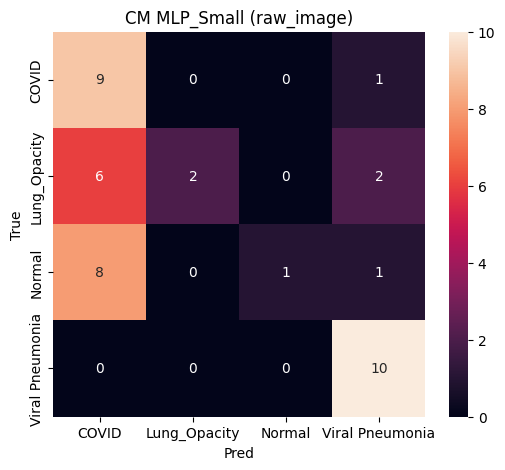

Reporte (raw):
                 precision  recall  f1-score  support
COVID             0.391304    0.90  0.545455    10.00
Lung_Opacity      1.000000    0.20  0.333333    10.00
Normal            1.000000    0.10  0.181818    10.00
Viral Pneumonia   0.714286    1.00  0.833333    10.00
accuracy          0.550000    0.55  0.550000     0.55
macro avg         0.776398    0.55  0.473485    40.00
weighted avg      0.776398    0.55  0.473485    40.00


In [159]:
# Escoger el mejor por f1_macro (por mode)
best_raw = summary_df[summary_df["mode"] == "raw_image"].sort_values("f1_macro", ascending=False).iloc[0]
best_lbp = summary_df[summary_df["mode"] == "lbp"].sort_values("f1_macro", ascending=False).iloc[0]
print("Mejor raw:", best_raw.model, " — Mejor lbp:", best_lbp.model)

# Encontrar en experiments
def find_experiment(model, mode):
    for e in experiments:
        if e['model']==model and e['mode']==mode:
            return e
    return None

exp = find_experiment(best_raw['model'], 'raw_image')
if exp:
    cm = exp['confusion_matrix']
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"CM {exp['model']} ({exp['mode']})")
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.show()
    print("Reporte (raw):")
    print(pd.DataFrame(exp['report']).transpose())
